# Import Packages

In [2]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import chi2, SelectKBest

# model imports
from sklearn.tree import DecisionTreeClassifier #decision tree model
from sklearn.ensemble import RandomForestClassifier #ensemble model
import xgboost as xgb

from sklearn.inspection import permutation_importance

from sklearn.metrics import classification_report, recall_score, precision_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import pickle

pd.options.display.max_columns = 100

## Function

In [3]:
def calculate_f1_scores_across_thresholds(model, X_val, y_val):
    """
    Calculate F1 scores for all thresholds from 0.0 to 1.0 with increment 0.01
    and find the threshold where F1 is maximal
    """
    
    # Get prediction probabilities
    y_prob = model.predict_proba(X_val)[:, 1]
    
    # Define threshold range from 0 to 1 with step 0.01
    thresholds = np.arange(0.0, 1.01, 0.01)
    
    precisions = []
    recalls = []
    f1_scores = []
    
    print("Calculating F1 scores for each threshold...")
    
    for threshold in thresholds:
        # Convert probabilities to predictions based on threshold
        y_pred = (y_prob >= threshold).astype(int)
        
        # Calculate precision and recall
        precision = precision_score(y_val, y_pred, zero_division=0)
        recall = recall_score(y_val, y_pred, zero_division=0)
        
        # Calculate F1 score using the formula: F1 = 2 * (P * R) / (P + R)
        if precision + recall == 0:
            f1 = 0.0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
        
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
    # Find the threshold with maximum F1 score
    max_f1_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[max_f1_idx]
    max_f1_score = f1_scores[max_f1_idx]
    optimal_precision = precisions[max_f1_idx]
    optimal_recall = recalls[max_f1_idx]
    
    # Create comprehensive plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: F1 Score vs Threshold
    axes[0, 0].plot(thresholds, f1_scores, 'g-', linewidth=2, marker='o', markersize=3)
    axes[0, 0].axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7, 
                       label=f'Max F1 at {optimal_threshold:.2f}')
    axes[0, 0].axhline(y=max_f1_score, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].set_xlabel('Threshold')
    axes[0, 0].set_ylabel('F1 Score')
    axes[0, 0].set_title(f'F1 Score vs Threshold\nMax F1: {max_f1_score:.3f} at threshold {optimal_threshold:.2f}')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_xlim([0, 1])
    axes[0, 0].set_ylim([0, 1])
    
    # Plot 2: Precision, Recall, and F1 together
    axes[0, 1].plot(thresholds, precisions, 'b-', label='Precision', linewidth=2)
    axes[0, 1].plot(thresholds, recalls, 'r-', label='Recall', linewidth=2)
    axes[0, 1].plot(thresholds, f1_scores, 'g-', label='F1 Score', linewidth=2)
    axes[0, 1].axvline(x=optimal_threshold, color='black', linestyle='--', alpha=0.7,
                       label=f'Optimal threshold: {optimal_threshold:.2f}')
    axes[0, 1].set_xlabel('Threshold')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_title('Precision, Recall, and F1 Score vs Threshold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_xlim([0, 1])
    axes[0, 1].set_ylim([0, 1])
    
    # Plot 3: Zoomed F1 Score around optimal threshold
    zoom_range = 0.1  # Show ±0.1 around optimal threshold
    zoom_min = max(0, optimal_threshold - zoom_range)
    zoom_max = min(1, optimal_threshold + zoom_range)
    
    zoom_mask = (thresholds >= zoom_min) & (thresholds <= zoom_max)
    axes[1, 0].plot(thresholds[zoom_mask], np.array(f1_scores)[zoom_mask], 'g-', 
                    linewidth=2, marker='o', markersize=4)
    axes[1, 0].axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.7)
    axes[1, 0].axhline(y=max_f1_score, color='red', linestyle='--', alpha=0.7)
    axes[1, 0].set_xlabel('Threshold')
    axes[1, 0].set_ylabel('F1 Score')
    axes[1, 0].set_title(f'F1 Score (Zoomed)\nAround Optimal Threshold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Bar chart showing top 10 F1 scores
    top_10_indices = np.argsort(f1_scores)[-10:]
    top_10_thresholds = thresholds[top_10_indices]
    top_10_f1_scores = np.array(f1_scores)[top_10_indices]
    
    bars = axes[1, 1].bar(range(len(top_10_thresholds)), top_10_f1_scores, 
                          color=['red' if t == optimal_threshold else 'skyblue' for t in top_10_thresholds])
    axes[1, 1].set_xlabel('Rank (Best to 10th Best)')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].set_title('Top 10 F1 Scores')
    axes[1, 1].set_xticks(range(len(top_10_thresholds)))
    axes[1, 1].set_xticklabels([f'{t:.2f}' for t in top_10_thresholds], rotation=45)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print("\n" + "="*60)
    print("F1 SCORE ANALYSIS RESULTS")
    print("="*60)
    print(f"Optimal Threshold: {optimal_threshold:.2f}")
    print(f"Maximum F1 Score: {max_f1_score:.3f}")
    print(f"Precision at optimal threshold: {optimal_precision:.3f}")
    print(f"Recall at optimal threshold: {optimal_recall:.3f}")
    print(f"F1 Formula verification: 2*P*R/(P+R) = 2*{optimal_precision:.3f}*{optimal_recall:.3f}/({optimal_precision:.3f}+{optimal_recall:.3f}) = {max_f1_score:.3f}")
    
    # Show top 5 thresholds with highest F1 scores
    print("\nTop 5 thresholds with highest F1 scores:")
    print("-" * 40)
    top_5_indices = np.argsort(f1_scores)[-5:][::-1]  # Get top 5 in descending order
    for i, idx in enumerate(top_5_indices, 1):
        print(f"{i}. Threshold: {thresholds[idx]:.2f}, F1: {f1_scores[idx]:.3f}, "
              f"Precision: {precisions[idx]:.3f}, Recall: {recalls[idx]:.3f}")
    
    return thresholds, f1_scores, optimal_threshold, max_f1_score

# Simple version for quick usage
def find_optimal_f1_threshold(model, X_val, y_val):
    """
    Simple function to find optimal F1 threshold and create basic plot
    """
    y_prob = model.predict_proba(X_val)[:, 1]
    thresholds = np.arange(0.0, 1.01, 0.01)
    
    f1_scores = []
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        precision = precision_score(y_val, y_pred, zero_division=0)
        recall = recall_score(y_val, y_pred, zero_division=0)
        
        if precision + recall == 0:
            f1 = 0.0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
        f1_scores.append(f1)
    
    # Find optimal threshold
    max_f1_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[max_f1_idx]
    max_f1_score = f1_scores[max_f1_idx]
    
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, 'g-', linewidth=2, marker='o', markersize=3)
    plt.axvline(x=optimal_threshold, color='red', linestyle='--', alpha=0.8, 
                label=f'Max F1: {max_f1_score:.3f} at {optimal_threshold:.2f}')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.title('F1 Score vs Threshold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.show()
    
    print(f"Optimal Threshold: {optimal_threshold:.2f}")
    print(f"Maximum F1 Score: {max_f1_score:.3f}")
    
    return optimal_threshold, max_f1_score

# Import Data 

In [4]:
df = pd.read_csv("../data/train.csv", sep=";")

df.sample(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
2374,41,admin.,married,university.degree,no,no,no,cellular,aug,wed,85,5,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,no
1248,32,blue-collar,single,high.school,no,no,yes,cellular,may,wed,204,3,999,0,nonexistent,-1.8,92.893,-46.2,1.281,5099.1,no
2336,25,blue-collar,married,basic.4y,no,no,no,cellular,may,fri,114,2,999,0,nonexistent,-1.8,92.893,-46.2,1.250,5099.1,no
543,47,blue-collar,married,high.school,no,unknown,unknown,cellular,aug,tue,153,10,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,no
1114,29,blue-collar,single,basic.9y,no,no,no,cellular,may,wed,68,1,999,0,nonexistent,-1.8,92.893,-46.2,1.281,5099.1,no


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             2999 non-null   int64  
 1   job             2999 non-null   object 
 2   marital         2999 non-null   object 
 3   education       2999 non-null   object 
 4   default         2999 non-null   object 
 5   housing         2999 non-null   object 
 6   loan            2999 non-null   object 
 7   contact         2999 non-null   object 
 8   month           2999 non-null   object 
 9   day_of_week     2999 non-null   object 
 10  duration        2999 non-null   int64  
 11  campaign        2999 non-null   int64  
 12  pdays           2999 non-null   int64  
 13  previous        2999 non-null   int64  
 14  poutcome        2999 non-null   object 
 15  emp.var.rate    2999 non-null   float64
 16  cons.price.idx  2999 non-null   float64
 17  cons.conf.idx   2999 non-null   f

In [6]:
df['y'] = df['y'].map({'yes':1, 'no':0})

# Model Development

## Exploratory Data Analysis

In [7]:
target = 'y'

numeric_features = [
    'age',
    'duration',
    'campaign',
    'previous',
    'emp.var.rate',
    'cons.price.idx',
    'cons.conf.idx',
    'euribor3m',
    'nr.employed'
]

categorical_features = [
    'job',
    'marital',
    'education',
    'default',
    'housing',
    'loan',
    'contact',
    'month',
    'day_of_week',
    'poutcome'
]

### Data Distribution & Correlation Analysis

<Axes: xlabel='y'>

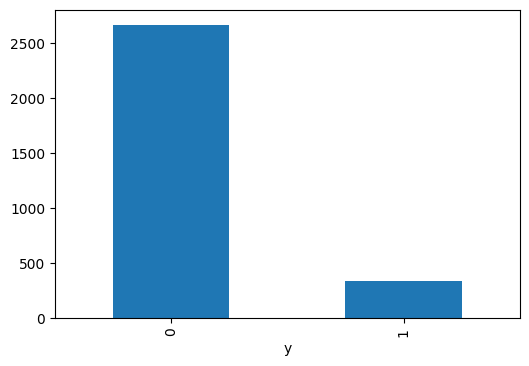

In [8]:
df.y.value_counts().plot(kind='bar', figsize=(6,4))

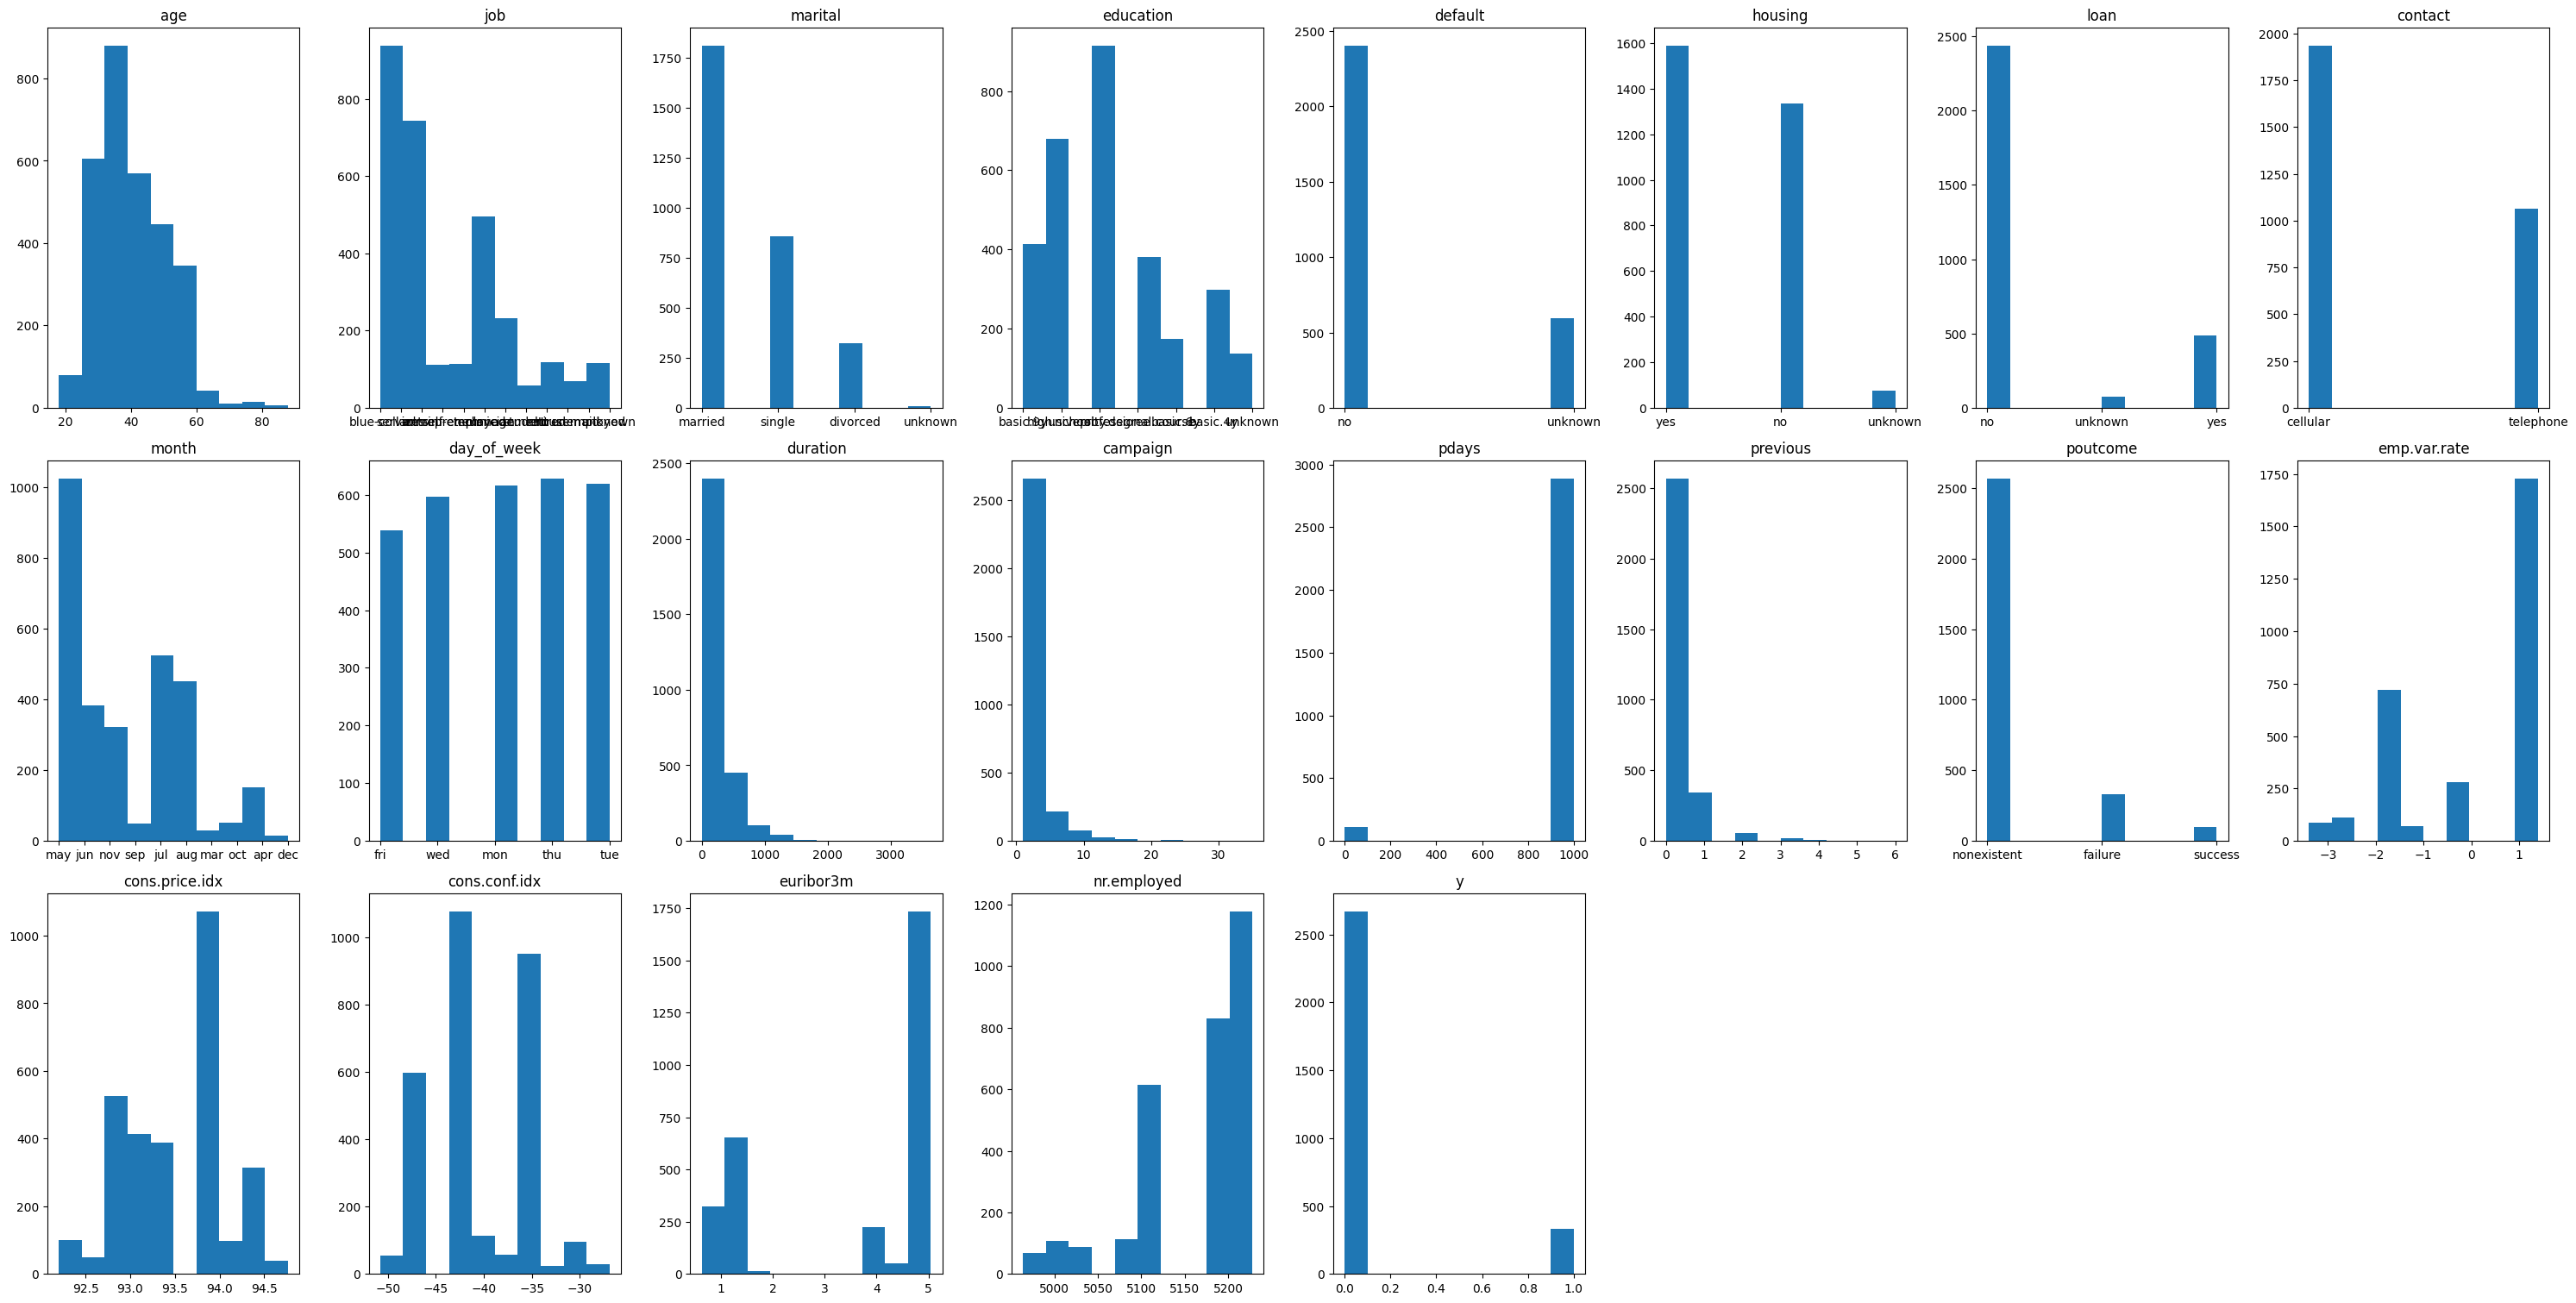

In [9]:
plt.figure(figsize=(30,20))
for ind,i in enumerate(df.columns):
    plt.subplot(4,8,ind+1)
    plt.title(i)
    plt.hist(i,data=df)
plt.tight_layout()
plt.show()

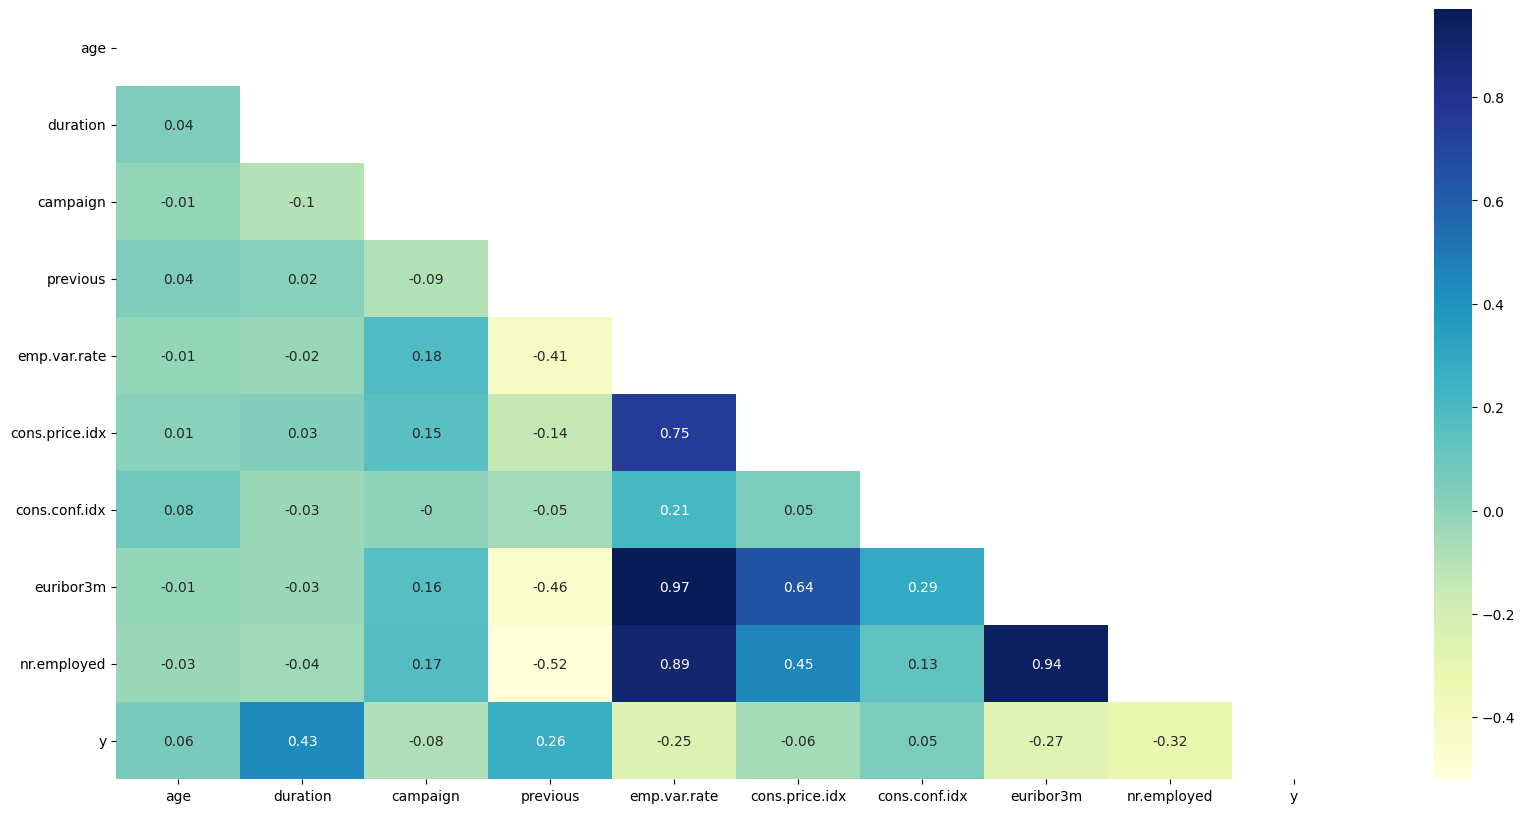

In [10]:
plt.figure(figsize=(20,10))
sns.heatmap(df[numeric_features + [target]].corr().round(2), cmap="YlGnBu", annot=True, mask = np.triu(np.ones_like(df[numeric_features + [target]].corr())))
plt.show()

#### Age Deep Dive

<Axes: xlabel='age', ylabel='Count'>

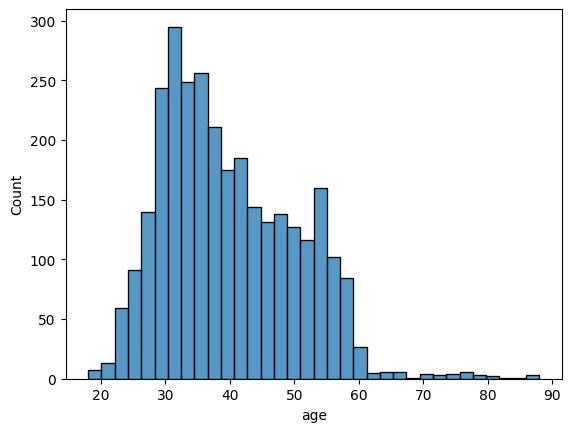

In [11]:
sns.histplot(data=df, x="age")

[Text(0, 0, '39.6735'), Text(0, 0, '41.6284')]

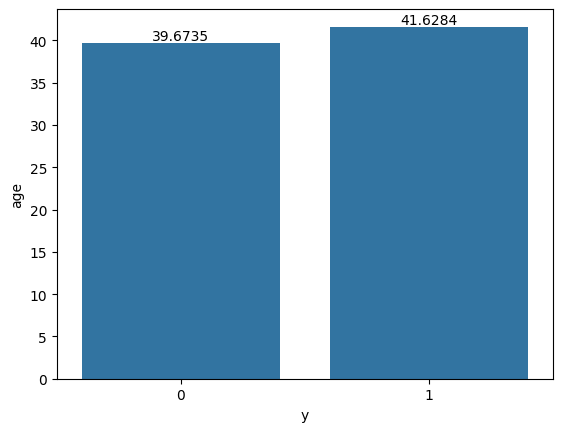

In [12]:
ax = sns.barplot(x='y', y='age', data=df, estimator=np.mean, errorbar=None)
ax.bar_label(ax.containers[0])

#### Duration Deep Dive

<Axes: xlabel='duration', ylabel='Count'>

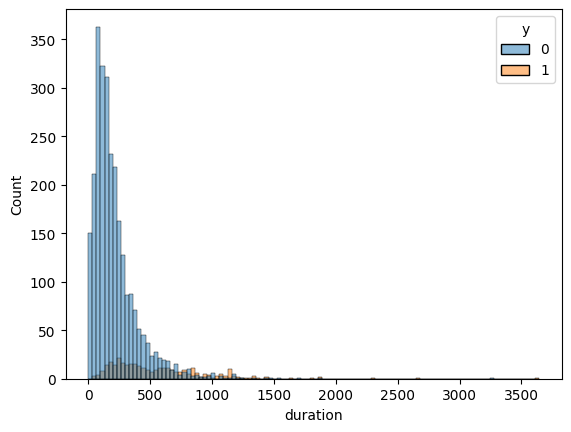

In [13]:
sns.histplot(data=df, x="duration", hue='y')

[Text(0, 0, '216.017'), Text(0, 0, '569.991')]

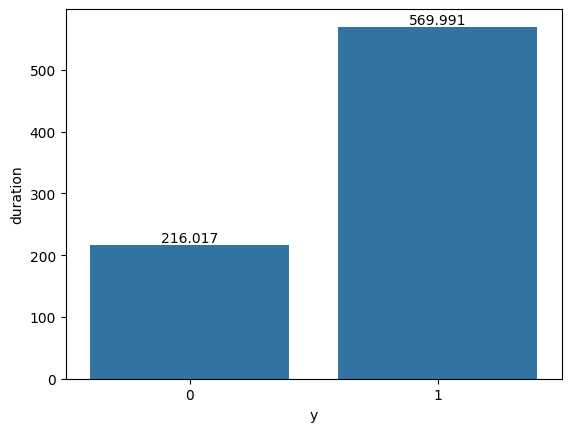

In [14]:
ax = sns.barplot(x='y', y='duration', data=df, estimator=np.mean, errorbar=None)
ax.bar_label(ax.containers[0])

#### Cons cof index

[Text(0, 0, '-41.8'), Text(0, 0, '-40.4')]

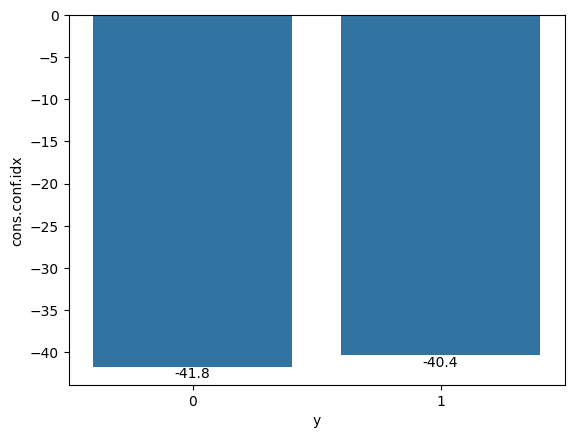

In [15]:
ax = sns.barplot(x='y', y='cons.conf.idx', data=df, estimator=np.median, errorbar=None)
ax.bar_label(ax.containers[0])

<Axes: xlabel='job'>

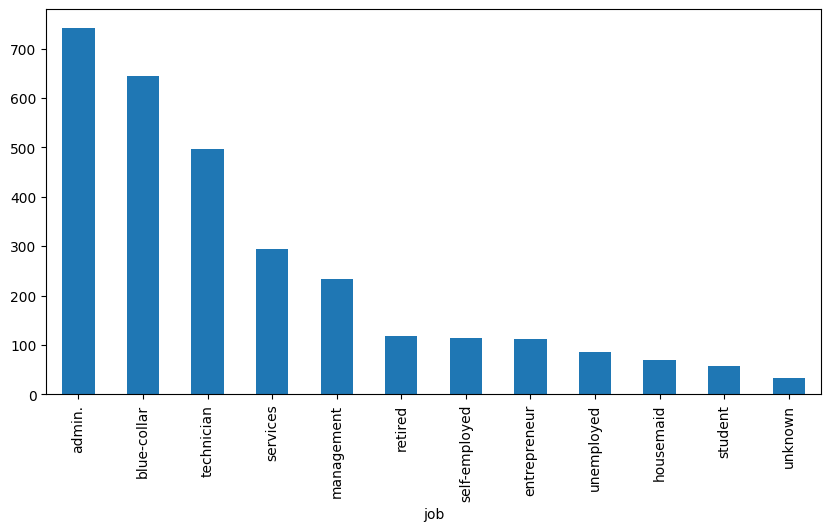

In [16]:
df['job'].value_counts().plot(kind='bar', figsize=(10,5))

## Feature Selection

### Numeric feature selection based on variance

In [17]:
df[numeric_features].columns

Index(['age', 'duration', 'campaign', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [18]:
df[numeric_features].loc[:, df[numeric_features].var() > 0.90].columns.tolist()

['age',
 'duration',
 'campaign',
 'emp.var.rate',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

### Categoric Feature Selection Based on Chi Square

In [19]:
le = LabelEncoder()

_df = df.copy()

for feature in categorical_features:    
    _df[feature] = le.fit_transform(_df[feature])
_df['default'] = le.fit_transform(_df['default'])

X = _df[categorical_features]
y = _df['y']

selector = SelectKBest(score_func=chi2, k=10)
selector.fit(X, y)

feature_scores = selector.scores_
selected_features_indices = selector.get_support(indices=True)
selected_feature_names = X.columns[selected_features_indices]

print("Chi-squared scores for each feature:", feature_scores)
print("Selected features:", selected_feature_names)

Chi-squared scores for each feature: [ 4.45433452  1.66244005 10.3876157   9.66358414  0.21320439  0.71234141
 31.57422926  0.1728208   0.08473684  6.60759115]
Selected features: Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')


In [20]:
pd.DataFrame({'Feature': X.columns, 'Chi2 Score': feature_scores}).sort_values(by='Chi2 Score', ascending=False)

,Feature,Chi2 Score
6,contact,31.574229
2,education,10.387616
3,default,9.663584
9,poutcome,6.607591
0,job,4.454335
1,marital,1.662440
5,loan,0.712341
4,housing,0.213204
7,month,0.172821
8,day_of_week,0.084737


### Insight

For feature selection implemented 2 kind of selection. For numeric feature we implement variance threshold, and field with low variance will be drop, while for categoric features we implement chi-square, and feature with less importance will be drop

1. Based on variance selection (threshold 0.9) we remove several features that are `previous, cons.price.idx`. With final numeric features are:
    - age
    - duration
    - campaign
    - emp.var.rate
    - cons.conf.idx
    - euribor3m
    - nr.employe


2. Based on chi-square feature selection we remove several features that are `loan, housing, month, and day_of_week`. With final categoric features are:
    - contact
    - education
    - default
    - poutcome
    - job
    - marital 

## Modeling

### Preparation for dataset

In [ ]:
numeric_features = [
    'age',
    'duration',
    'campaign',
    'emp.var.rate',
    'cons.conf.idx',
    'euribor3m',
    'nr.employed'
]

categorical_features = [
    'job',
    'marital',
    'education',
    'default',
    'contact',
    'poutcome'
]

In [ ]:
[numeric_features + categorical_features]

[['age',
  'duration',
  'campaign',
  'emp.var.rate',
  'cons.conf.idx',
  'euribor3m',
  'nr.employed',
  'job',
  'marital',
  'education',
  'default',
  'contact',
  'poutcome']]

In [ ]:
df[numeric_features + categorical_features]

,age,duration,campaign,emp.var.rate,cons.conf.idx,euribor3m,nr.employed,job,marital,education,default,contact,poutcome
0,30,487,2,-1.8,-46.2,1.313,5099.1,blue-collar,married,basic.9y,no,cellular,nonexistent
1,39,346,4,1.1,-36.4,4.855,5191.0,services,single,high.school,no,telephone,nonexistent
2,25,227,1,1.4,-41.8,4.962,5228.1,services,married,high.school,no,telephone,nonexistent
3,38,17,3,1.4,-41.8,4.959,5228.1,services,married,basic.9y,no,telephone,nonexistent
4,47,58,1,-0.1,-42.0,4.191,5195.8,admin.,married,university.degree,no,cellular,nonexistent
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2994,47,159,1,-1.8,-46.2,1.334,5099.1,blue-collar,single,basic.9y,unknown,cellular,nonexistent
2995,53,37,13,1.1,-36.4,4.856,5191.0,admin.,married,university.degree,no,telephone,nonexistent
2996,60,338,2,-1.1,-49.5,1.000,4963.6,retired,married,university.degree,no,cellular,nonexistent
2997,32,485,1,-0.1,-42.0,4.076,5195.8,technician,single,university.degree,no,cellular,failure


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    df[numeric_features + categorical_features].copy(),
    df['y'].copy(),
    test_size=0.2,
    random_state=42,
    stratify=df['y']
)

### Preparation for Pipeline

In [37]:
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

In [39]:
# handling imbalance class with class_weight & scale_pos_weight

dtree_pipeline = Pipeline(steps=[
    ('vectorizer', DictVectorizer()),
    ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

rf_pipeline = Pipeline(steps=[
    ('vectorizer', DictVectorizer()),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

xgb_pipeline = Pipeline(steps=[
    ('vectorizer', DictVectorizer()),
    ('classifier', xgb.XGBClassifier(scale_pos_weight = scale_pos_weight, random_state=42))
])

### Model Training

In [40]:
model_dt = dtree_pipeline.fit(X_train.to_dict(orient='records'), y_train)
model_rf = rf_pipeline.fit(X_train.to_dict(orient='records'), y_train)
model_xgb = xgb_pipeline.fit(X_train.to_dict(orient='records'), y_train)

In [45]:
print("Decision Tree Performance on Validation Set")
print(f"{'-'*100}")
print("Classification Report:")
print(classification_report(y_val, model_dt.predict(X_val.to_dict(orient='records'))))
print(f"{'-'*100}")
print(f"F1 Score:{f1_score(y_val, model_dt.predict(X_val.to_dict(orient='records')))}")

Decision Tree Performance on Validation Set
----------------------------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       534
           1       0.48      0.45      0.47        66

    accuracy                           0.89       600
   macro avg       0.70      0.70      0.70       600
weighted avg       0.88      0.89      0.88       600

----------------------------------------------------------------------------------------------------
F1 Score:0.46511627906976744


In [46]:
print("Random Forest Performance on Validation Set")
print(f"{'-'*100}")
print("Classification Report:")
print(classification_report(y_val, model_rf.predict(X_val.to_dict(orient='records'))))
print(f"{'-'*100}")
print(f"F1 Score:{f1_score(y_val, model_rf.predict(X_val.to_dict(orient='records')))}")

Random Forest Performance on Validation Set
----------------------------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       534
           1       0.65      0.33      0.44        66

    accuracy                           0.91       600
   macro avg       0.78      0.66      0.69       600
weighted avg       0.89      0.91      0.89       600

----------------------------------------------------------------------------------------------------
F1 Score:0.44


In [49]:
print("XGBoost Performance on Validation Set")
print(f"{'-'*100}")
print("Classification Report:")
print(classification_report(y_val, model_xgb.predict(X_val.to_dict(orient='records'))))
print(f"{'-'*100}")
print(f"F1 Score:{f1_score(y_val, model_xgb.predict(X_val.to_dict(orient='records')))}")

XGBoost Performance on Validation Set
----------------------------------------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       534
           1       0.56      0.61      0.58        66

    accuracy                           0.91       600
   macro avg       0.76      0.77      0.77       600
weighted avg       0.91      0.91      0.91       600

----------------------------------------------------------------------------------------------------
F1 Score:0.583941605839416


Based on test on 3 models: **Decision tree classifier, random forest classifier, and xgboost classifier**. We found that XGBoost outperform others 2 models. Hence we will proceed XGBoost Classifier to hyperparameter tuning for increasing its **f1 score** as this is imbalance class and f1 score is most suitable metrics for the models

## Optimizing Best Base Model (Hyperparameter Tuning)